In [5]:
import numpy as np
from matplotlib import pyplot as plt

from wpg.optical_elements import Drift, Mirror_plane_2d
from wpg.wpg_uti_oe import propagation_parameters
from wpg.source import sase_pulse
from midsim.source import analytical_pulse_divergence, analytical_pulse_width

from wpg.beamline import Beamline

In [6]:
M1 = Mirror_plane_2d('x', theta = 1.2e-03, length = 848.7e-03,range_xy=19.2e-3,filename = '/home/guestt/midsim/midsim/data/SA2_M1_HeightErr.txt', nx = 1024)
M2 = Mirror_plane_2d('x', theta = 1.2e-03, length = 848.7e-03,range_xy=19.2e-3,filename = '/home/guestt/midsim/midsim/data/SA2_M1_HeightErr.txt', nx = 1024)

In [7]:
from matplotlib.colors import LogNorm, Normalize

def plot_wfr(wfr, logscale=False, title = None):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    intensity = wfr.get_intensity().sum(-1)
    
    if logscale:
        norm = LogNorm(vmin=intensity[intensity > 0].min(), vmax=intensity.max())
    else:
        norm = Normalize(vmin=intensity.min(), vmax=intensity.max())
    
    try:
        extent =  [a*1e3 for a in [wfr.xMin, wfr.xMax, wfr.yMin, wfr.yMax]]
        
    except(TypeError):
        extent =  [a*1e3 for a in [wfr.qxMin, wfr.qxMax, wfr.qyMin, wfr.qyMax]]

    im = ax.imshow(intensity,
                   extent=extent,
                   cmap='afmhot',
                   norm=norm)
    
    ax.set_xlabel('x (mm)')
    ax.set_xlabel('y (mm)')
    
    if title:
        ax.set_title(title)
    fig.colorbar(im, ax=ax, orientation='vertical')


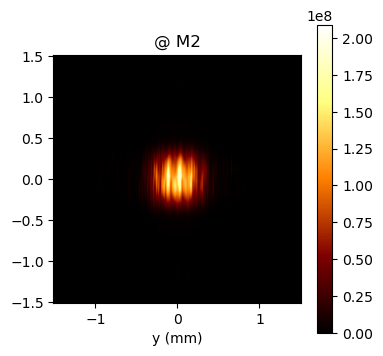

In [18]:
x = y = np.linspace(-500e-06, 500e-06, 512)
t = np.linspace(-50e-15, 50e-15, 2)

theta_y = 0
photon_energy = 10e3


theta_x = 0

wfr = sase_pulse(x=x,
                        y=y,
                        t=t,
                        photon_energy=photon_energy,
                        pulse_energy=1e-03,
                        pulse_duration=15e-15,
                        bandwidth=1e-12,
                        sigma=analytical_pulse_width(photon_energy),
                        div=analytical_pulse_divergence(photon_energy),
                        x0=0.0,
                        y0=0.0,
                        t0=0.0,
                        theta_x=theta_x,
                        theta_y=0.0,
                        domain='freq',
                        polarization = 'horizontal')



bl = Beamline()
bl.append(Drift(290), propagation_parameters(3,1,3,1,mode = 'fresnel'))
bl.append(M1, propagation_parameters(1,1,1,1, mode = 'fresnel'))

bl.append(Drift(11), propagation_parameters(1,1,1,1,mode = 'fresnel'))
bl.append(M2, propagation_parameters(1,1,1,1, mode = 'fresnel'))
bl.append(Drift(90), propagation_parameters(1,1,1,1,mode = 'fresnel'))
bl.propagate(wfr)

plot_wfr(wfr, title = "@ M2")

In [ ]:
T.mesh.a

AttributeError: 'SRWLRadMesh' object has no attribute 'a'